### COMMON PORTION

In [ ]:
import numpy as np
import cv2

# Load an color image in grayscale
#img = cv2.imread('/content/drive/My Drive/SINP-MUST images for analysis/Tissue samples(Diseased and normal stained with lamin A and B)/Green Channel for lamin B (Diseased and Normal)/Diseased LB/Diseased Omentum LB (1 samples-2 sites-15fields each)/C1-W4.jpg',0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from os import listdir
from os.path import isfile, join
import numpy
import cv2
def load_data(mypath):
  onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
  images = numpy.empty(len(onlyfiles), dtype=object)
  for n in range(0, len(onlyfiles)):
    images[n] = cv2.imread( join(mypath,onlyfiles[n]) )
    print("Loading {} Image".format(n))
  return(images)

In [ ]:
cancer_path = '/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/cancer'
normal_path = '/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/normal'

cancer_x = load_data(cancer_path)
normal_x = load_data(normal_path)

In [ ]:
print(f"Cancer Data Set Size==> {len(cancer_x)}")
print(f"Normal Data Set Size==> {len(normal_x)}")

Cancer Data Set Size==> 262
Normal Data Set Size==> 52


In [ ]:
cv2_imshow(cancer_x[101]) # 21, 42

### Setting Infra

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input, Conv2D, MaxPooling2D
from keras.optimizers import Adam, Adadelta
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix

### Loading Data

In [ ]:
# train_dir = '/content/drive/My Drive/SINP-MUST images for analysis'
train_dir = '/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/'
# test_dir = '/content/drive/My Drive/SINP-MUST images for analysis/test/test'
# sample_submission = pd.read_csv('../input/plant-seedlings-classification/sample_submission.csv')

In [ ]:
# cancer_path = '/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/cancer'
# normal_path = '/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/normal'

train = []
SPECIES = ['normal', 'cancer']
for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(train_dir, species)):
        # train.append(['/content/drive/My Drive/SINP-MUST images for analysis/{}/{}'.format(species, file), species_num, species])
        train.append(['/content/drive/My Drive/SINP-MUST images for analysis/NEW IMAGES/{}/{}'.format(species, file), species_num, species])
        
train = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data: ',train.shape)

Training Data:  (314, 3)


In [ ]:
train[:1]

,file,species_num,species
0,/content/drive/My Drive/SINP-MUST images for a...,0,normal


### Pre-Processing

In [ ]:
def create_mask_for_image(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])
 
    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask
 
def segment_image(image):
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
 
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

In [ ]:
x_train = []

for i in range(len(train)):
    print(train['file'][i])
    img = cv2.imread(train['file'][i])
    # cv2_imshow(img)
    # img = cv2.resize(img,dsize=(256,256))
    img_stack = segment_image(img)
    img_stack = sharpen_image(img_stack)
    img_stack = cv2.cvtColor( img_stack, cv2.COLOR_RGB2GRAY )
    img_stack = np.reshape(img_stack,(1024,1024,1))
    x_train.append(np.concatenate((np.array(img),np.array(img_stack)),axis=2))

x_train = np.array(x_train)

In [ ]:
x_train.shape

(314, 1024, 1024, 4)

In [ ]:
cv2_imshow(x_train[240])

In [ ]:
labels = train['species_num']
# labels = to_categorical(labels, num_classes = len(SPECIES))

In [ ]:
# x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size = 0.3)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train,labels,
                                                    stratify=labels, 
                                                    test_size=0.25)

In [ ]:
input_shape = x_train[1].shape
print('Input Shape is :', input_shape)

Input Shape is : (1024, 1024, 4)


In [ ]:
labels.value_counts()

1    262
0     52
Name: species_num, dtype: int64

### Applying UP-SAMPLING

In [ ]:
type(x_train[0])

numpy.ndarray

In [ ]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 

# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
x_train_res, y_train_res = sm.fit_sample(x_train.reshape(x_train.shape[0], -1), y_train) 

print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0))) 


Before OverSampling, counts of label '1': 196
Before OverSampling, counts of label '0': 39 

After OverSampling, the shape of train_X: (392, 4194304)
After OverSampling, the shape of train_y: (392,) 

After OverSampling, counts of label '1': 196
After OverSampling, counts of label '0': 196


In [ ]:
y_train_res = to_categorical(y_train_res, num_classes = len(SPECIES))

In [ ]:
y_val = to_categorical(y_val, num_classes = len(SPECIES))

In [ ]:
x_train_res.shape

(392, 4194304)

In [ ]:
x_train_res = x_train_res.reshape(x_train_res.shape[0], 1024, 1024, 4)

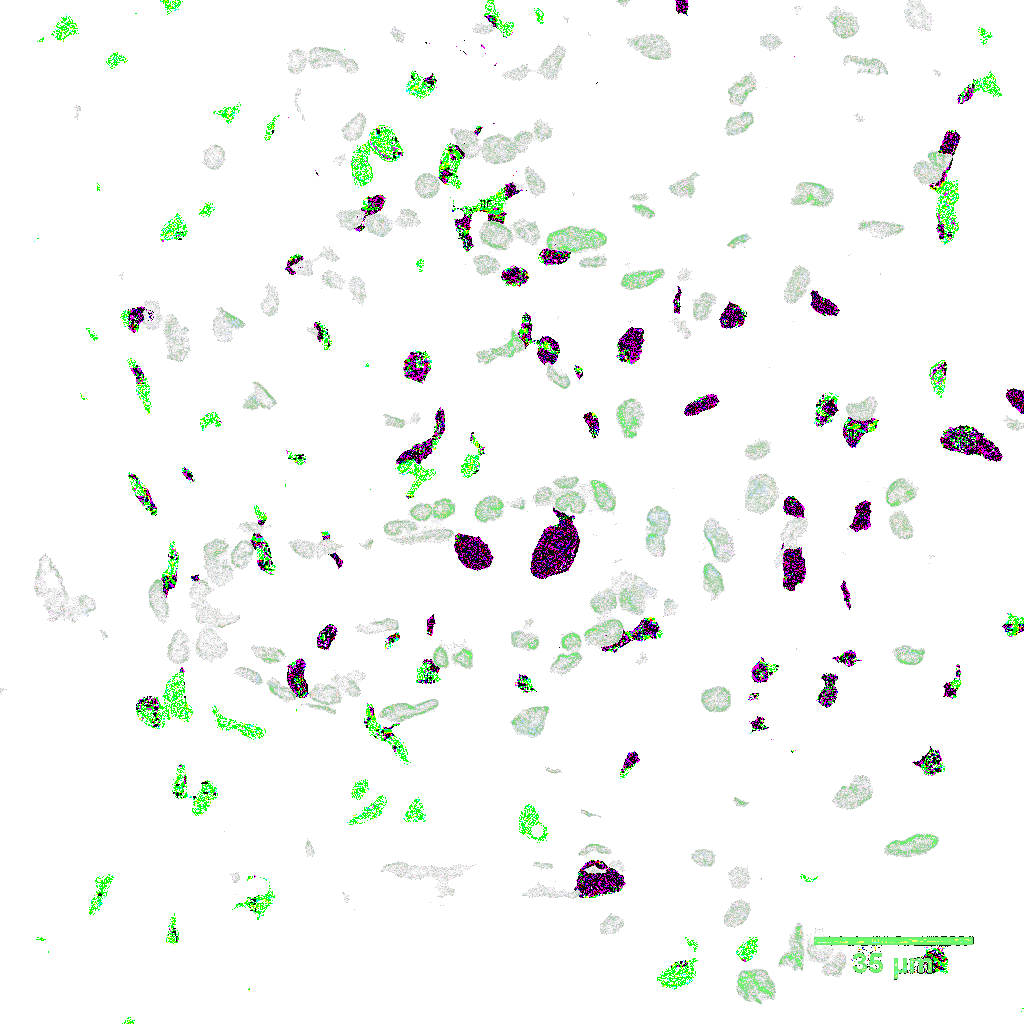

In [ ]:
cv2_imshow(x_train_res[300])

### END OF COMMON

In [ ]:
#cancer_x = cancer_x.reshape(len(cancer_x),1)
#normal_x = normal_x.reshape(len(normal_x),1)

In [ ]:
normal_x.shape

(33,)

In [ ]:
whole_data = np.concatenate((cancer_x,normal_x),axis=0)

In [ ]:
cv2_imshow(whole_data[182])

In [ ]:
cancer_y = np.ones(cancer_x.shape[0])
normal_y = np.zeros(normal_x.shape[0])

In [ ]:
normal_y.shape

(33,)

In [ ]:
whole_label = np.concatenate((cancer_y,normal_y),axis=0)

In [ ]:
labels = whole_label
labels = to_categorical(labels, num_classes = 2)

# TRAIN AND TEST SPLITTING

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(all_img,whole_label,
#                                                     stratify=whole_label, 
#                                                     test_size=0.30)

In [ ]:
# i = 20
# cv2_imshow(x_test[i])
# # print(x_train[i])

### MODEL ARCHITECTURE DEFINATION

In [ ]:
def fire_incept(x, fire=16, intercept=64):
    x = Conv2D(fire, (5,5), strides=(2,2))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (3,3), padding='same')(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (5,5), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x
 
def fire_squeeze(x, fire=16, intercept=64):
    x = Conv2D(fire, (1,1))(x)
    x = LeakyReLU(alpha=0.15)(x)
    
    left = Conv2D(intercept, (1,1))(x)
    left = LeakyReLU(alpha=0.15)(left)
    
    right = Conv2D(intercept, (3,3), padding='same')(x)
    right = LeakyReLU(alpha=0.15)(right)
    
    x = concatenate([left, right], axis=3)
    return x
 
image_input=Input(shape=input_shape)
 
x = fire_incept((image_input), fire=16, intercept=16)
 
x = fire_incept(x, fire=32, intercept=32)
x = fire_squeeze(x, fire=32, intercept=32)
 
x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)
 
x = fire_incept(x, fire=64, intercept=64)
x = fire_squeeze(x, fire=64, intercept=64)
 
x = Conv2D(64, (3,3))(x)
x = LeakyReLU(alpha=0.1)(x)
 
x = Flatten()(x)
 
x = Dense(512)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.1)(x)
 
out = Dense(2, activation='softmax')(x)
 
model_new = Model(image_input, out)
model_new.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 510, 510, 16) 1616        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 510, 510, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 510, 510, 16) 2320        leaky_re_lu[0][0]                
_______________________________________________________________________________________

### Model Compilation

In [ ]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score

# def auroc(y_true, y_pred):
#     return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

model_new.compile(optimizer = Adam(lr=.00025) , loss = 'categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

Set a learning rate annealer

In [ ]:
from keras.callbacks import ModelCheckpoint
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, 
#                                             factor=0.5, min_lr=0.00001)
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

Data Augmentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=40, zoom_range = 0.2, width_shift_range=0.2, height_shift_range=0.2,
                             horizontal_flip=True, vertical_flip=True)
datagen.fit(x_train)

In [ ]:
batch_size = 16
epochs = 250

In [ ]:
print('X_TEST:  ' + str(len(x_val)))
print('Y_TEST:  '+ str(len(y_val)))
print('X_TRAIN: ' + str(len(x_train_res)))
print('Y_TRAIN: ' + str(len(y_train_res)))

X_TEST:  79
Y_TEST:  79
X_TRAIN: 392
Y_TRAIN: 392


In [ ]:
history = model_new.fit_generator(datagen.flow(x_train_res,y_train_res, batch_size=batch_size), epochs = epochs,
                                  validation_data = (x_val,y_val), verbose = 1, 
                                  steps_per_epoch=x_train.shape[0] // batch_size, 
                                  callbacks=[checkpoint])

Epoch 1/250
14/14 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8348 - auc: 0.9160
Epoch 00001: val_accuracy did not improve from 0.83544
14/14 [==============================] - 56s 4s/step - loss: 0.3611 - accuracy: 0.8348 - auc: 0.9160 - val_loss: 0.4195 - val_accuracy: 0.7848 - val_auc: 0.9072
Epoch 2/250
14/14 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.8194 - auc: 0.9261
Epoch 00002: val_accuracy did not improve from 0.83544
14/14 [==============================] - 54s 4s/step - loss: 0.3288 - accuracy: 0.8194 - auc: 0.9261 - val_loss: 0.4221 - val_accuracy: 0.8354 - val_auc: 0.8979
Epoch 3/250
14/14 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8657 - auc: 0.9460
Epoch 00003: val_accuracy improved from 0.83544 to 0.84810, saving model to weights-improvement-03-0.85.hdf5
14/14 [==============================] - 61s 4s/step - loss: 0.2902 - accuracy: 0.8657 - auc: 0.9460 - val_loss: 0.2513 - val_accura

In [ ]:
model_new.save_weights('/content/drive/My Drive/SINP-MUST images for analysis/Trained Models/SMOTE_EXTRA_SAMPLE_CNN_MODEL.h5')

In [ ]:
y_pred = model_new.predict(x_val)
matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print('Validation Set Confusion Matrix')
print(matrix)

Validation Set Confusion Matrix
[[10  3]
 [ 0 66]]


In [ ]:
y_pred = model_new.predict(x_train)
matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
print('Train Set Confusion Matrix')
print(matrix)

Train Set Confusion Matrix
[[189   7]
 [  0 196]]


In [ ]:
# from tensorflow import keras
# # model = keras.models.load_model('/content/drive/My Drive/SINP-MUST images for analysis/Trained Models/2ND_BEST_CNN_MODEL.index')
# from numpy import loadtxt
# from keras.models import load_model

# model = load_model('/content/drive/My Drive/SINP-MUST images for analysis/Trained Models/2ND_BEST_CNN_MODEL_temp_b25baedba906420f8cdbd199e4dad4b5')

In [ ]:
confusion_matrix(y_val, model_new.predict_classes(x_val, batch_size=128, verbose=0))

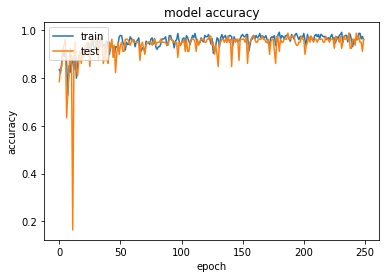

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

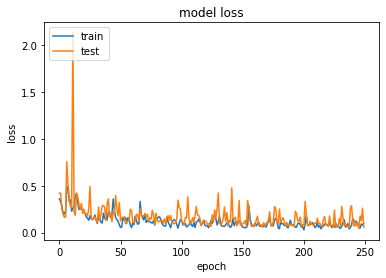

In [ ]:
from tensorflow import keras
# model = keras.models.load_model('path/to/location')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Combining SVM with CNN

In [ ]:
model_feat = Model(inputs=model_new.input,outputs=model_new.get_layer('dense').output)

In [ ]:
feat_train = model_feat.predict(x_train_res)
print(feat_train.shape)

feat_val = model_feat.predict(x_val)
print(feat_val.shape)

# feat_test = model_feat.predict(x_val)
# print(feat_test.shape)

(392, 512)
(79, 512)


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')

svm.fit(feat_train,np.argmax(y_train_res,axis=1))

print('fitting done !!!')

fitting done !!!


In [ ]:
svm.score(feat_train,np.argmax(y_train_res,axis=1))

0.8801020408163265

In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_train_res, axis=1),svm.predict(feat_train))
print('SVM --> Validation Set Confusion Matrix')
print(matrix)

SVM --> Validation Set Confusion Matrix
[[149  47]
 [  0 196]]


In [ ]:
svm.score(feat_val,np.argmax(y_val,axis=1))

0.8734177215189873

In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_val, axis=1),svm.predict(feat_val))
print('SVM --> Validation Set Confusion Matrix')
print(matrix)

SVM --> Validation Set Confusion Matrix
[[ 3 10]
 [ 0 66]]


### Applying XGB

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier()

xb.fit(feat_train,np.argmax(y_train_res,axis=1))

print('fitting done !!!')

fitting done !!!


In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_val, axis=1),xb.predict(feat_val))
print('XGboost --> Validation Set Confusion Matrix')
print(matrix)

XGboost --> Validation Set Confusion Matrix
[[13  0]
 [ 1 65]]


In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_train_res, axis=1),xb.predict(feat_train))
print('XGboost --> Training Set Confusion Matrix')
print(matrix)

XGboost --> Training Set Confusion Matrix
[[195   1]
 [  0 196]]


In [ ]:
xb.score(feat_train,np.argmax(y_train_res,axis=1))

0.9974489795918368

In [ ]:
xb.score(feat_test,np.argmax(y_test,axis=1))

0.9873417721518988

### Applying Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
clf = RandomForestClassifier(max_depth=4, random_state=0)

In [ ]:
clf.fit(feat_train,np.argmax(y_train_res,axis=1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_train_res, axis=1),clf.predict(feat_train))
print('XGboost --> Training Set Confusion Matrix')
print(matrix)

XGboost --> Training Set Confusion Matrix
[[195   1]
 [  0 196]]


In [ ]:
# matrix = confusion_matrix(y_train_res.argmax(axis=1), model_new.predict(x_train_res).argmax(axis=1))
matrix = confusion_matrix(np.argmax(y_val, axis=1),clf.predict(feat_val))
print('XGboost --> Validation Set Confusion Matrix')
print(matrix)

XGboost --> Validation Set Confusion Matrix
[[13  0]
 [ 1 65]]


In [ ]:
print('Random Forest Training Accuracy')
clf.score(feat_train,np.argmax(y_train_res,axis=1))

Random Forest Training Accuracy


0.9974489795918368

In [ ]:
print('Random Forest Validation Accuracy')
clf.score(feat_val,np.argmax(y_val,axis=1))

Random Forest Validation Accuracy


0.9873417721518988